<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Route-and-Path-Info" data-toc-modified-id="Load-Route-and-Path-Info-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Route and Path Info</a></span></li><li><span><a href="#Aggregate-Fuel-Info-by-HRS" data-toc-modified-id="Aggregate-Fuel-Info-by-HRS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Aggregate Fuel Info by HRS</a></span></li><li><span><a href="#HRS-Size-Bar-Chart" data-toc-modified-id="HRS-Size-Bar-Chart-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HRS Size Bar Chart</a></span></li></ul></div>

In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from LH_MODULE_CONFIG import SCRATCH_FOLDER, OUTPUT_FOLDER, SCENARIO_ROOT
sys.path.insert(0, SCENARIO_ROOT)
from SCENARIO_CONFIG import LH_FCEV_KMPkgH2, FCEV_VOLUME_PROPORTION_IN_HCV

Active scenario: Baseline


## Load Route and Path Info

In [2]:
routes = pd.read_csv(os.path.join(SCRATCH_FOLDER, 'Routes.csv'))
display(routes.head())
print('Total volume on all routes:', routes['volume'].sum())

,route_id,orig_node_id,dest_node_id,volume,path_id
0,0,13,18,40940.5,0
1,1,18,13,40940.5,1
2,2,12,13,3447.5,2
3,3,12,18,3447.5,3
4,4,25,13,245.0,4


Total volume on all routes: 1346268.0


In [3]:
Path_fuel_info = pd.read_csv(os.path.join(SCRATCH_FOLDER, 'Paths_fuel_km.csv'))
Path_fuel_info.head()

,path_id,refuel_at,fuel_km
0,0,18,145.0
1,1,18,120.0
2,3,18,163.0
3,4,51,233.0
4,4,19,88.0


In [4]:
Nodes_info = pd.read_csv(os.path.join(SCRATCH_FOLDER, 'Nodes_info.csv'))
Nodes_info.head()

,node_id,node_name,lon,lat,OD,county_long,county_short,County_No
0,1,Redding,-122.360642,40.585450,1,Shasta County,Shasta,45
1,2,Red Bluff,-122.224084,40.179209,1,Tehama County,Tehama,52
2,3,Dunnigan,-121.953458,38.860841,0,Yolo County,Yolo,57
3,4,Woodland,-121.755159,38.689872,0,Yolo County,Yolo,57
4,5,SMF,-121.593640,38.671090,1,Sacramento County,Sacramento,34


## Aggregate Fuel Info by HRS

In [8]:
path_fuel = pd.merge(Path_fuel_info, routes, how='left', on='path_id')
# path_fuel['fuel_mile'] = path_fuel['fuel_km']/1.609
path_fuel['fcev_volume'] = path_fuel['volume'] * FCEV_VOLUME_PROPORTION_IN_HCV
path_fuel['fuel_kgH2'] = path_fuel['fuel_km'] / LH_FCEV_KMPkgH2 * path_fuel['fcev_volume']
path_fuel.head()

,path_id,refuel_at,fuel_km,route_id,orig_node_id,dest_node_id,volume,fcev_volume,fuel_kgH2
0,0,18,145.0,0,13,18,40940.5,818.81,8188.100000
1,1,18,120.0,1,18,13,40940.5,818.81,6776.358621
2,3,18,163.0,3,12,18,3447.5,68.95,775.093103
3,4,51,233.0,4,25,13,245.0,4.90,78.737931
4,4,19,88.0,4,25,13,245.0,4.90,29.737931


In [9]:
hrs_fuel = path_fuel.groupby('refuel_at')[['fuel_kgH2']].sum()
hrs_fuel.rename_axis('hrs_node_id', axis=0, inplace=True)
hrs_fuel.rename(columns={'fuel_kgH2': 'daily_kgH2'}, inplace=True)
hrs_fuel = pd.merge(hrs_fuel, Nodes_info[['node_id', 'node_name']], how='left', left_index=True, right_on='node_id')
hrs_fuel.rename(columns={'node_id':'hrs_node_id'}, inplace=True)
hrs_fuel = hrs_fuel[['hrs_node_id', 'node_name', 'daily_kgH2']]
hrs_fuel.sort_values('daily_kgH2', ascending=False, inplace=True)
hrs_fuel

,hrs_node_id,node_name,daily_kgH2
32,34,East LA,52153.775862
17,18,Hayward,26523.635862
31,33,Irvine,17067.445057
16,17,San Jose,14108.481379
68,70,Oceanside,3857.005517
18,19,Stockton,3517.586897
65,67,Lebec,2353.783448
42,44,Harris Ranch,2042.913103
10,11,Vacaville,1031.357931
49,51,Livingston,786.400000


In [11]:
hrs_fuel.to_csv(os.path.join(OUTPUT_FOLDER, 'HRS_Daily_kgH2.csv'))

## HRS Size Bar Chart

In [12]:
# import seaborn as sns
# print('Seaborn version:', sns.__version__)

In [13]:
plt.style.use('seaborn-paper')

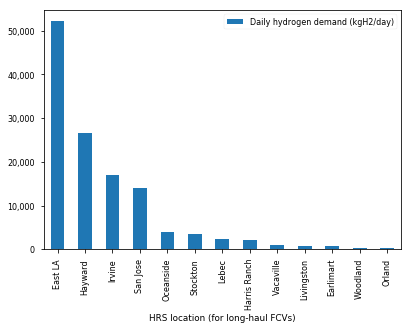

In [14]:
ax = hrs_fuel[['daily_kgH2']].plot.bar()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax.set_xticklabels(hrs_fuel.node_name)
ax.set_xlabel('HRS location (for long-haul FCVs)')
ax.legend(['Daily hydrogen demand (kgH2/day)'])

plt.savefig(os.path.join(OUTPUT_FOLDER, 'LH HRS Sizes.png'), bbox_inches='tight')